In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Users/jbred/OneDrive/Desktop/retail-forecasting/data/raw/sales.csv")

print("Shape:", df.shape)
print(df.head())
print(df.info())


Shape: (6435, 8)
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  

In [4]:
%pip install pandas numpy matplotlib scikit-learn xgboost prophet streamlit joblib boto3


  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/113.8 kB ? eta -:--:--
     --- ------------------------------------ 10.2/113.8 kB ? eta -:--:--
     ------------- ----------------------- 41.0/113.8 kB 388.9 kB/s eta 0:00:01
     -----------------------------------  112.6/113.8 kB 819.2 kB/s eta 0:00:01
     ------------------------------------ 113.8/113.8 kB 734.7 kB/s eta 0:00:00
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.81-py3-none-any.whl.metadata (49 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/44.3 kB ? eta -:--:--
     ---------------------------------------- 44.3/44.3 kB 1.1 MB/s eta 0:00:00
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/8.1 MB ? et

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


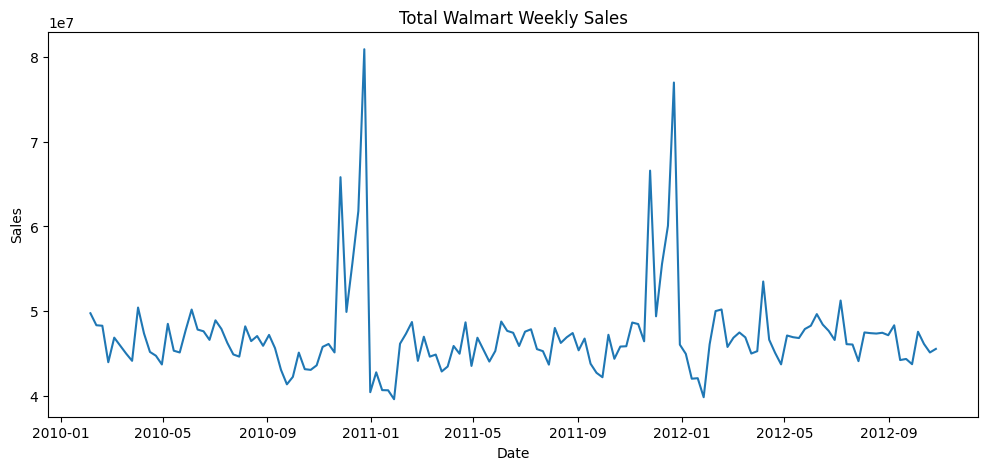

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("C:/Users/jbred/OneDrive/Desktop/retail-forecasting/data/raw/sales.csv")
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

# Aggregate daily sales
daily_sales = df.groupby("Date")["Weekly_Sales"].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(daily_sales["Date"], daily_sales["Weekly_Sales"])
plt.title("Total Walmart Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


c:\Users\jbred\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
11:51:44 - cmdstanpy - INFO - Chain [1] start processing
11:51:47 - cmdstanpy - INFO - Chain [1] done processing


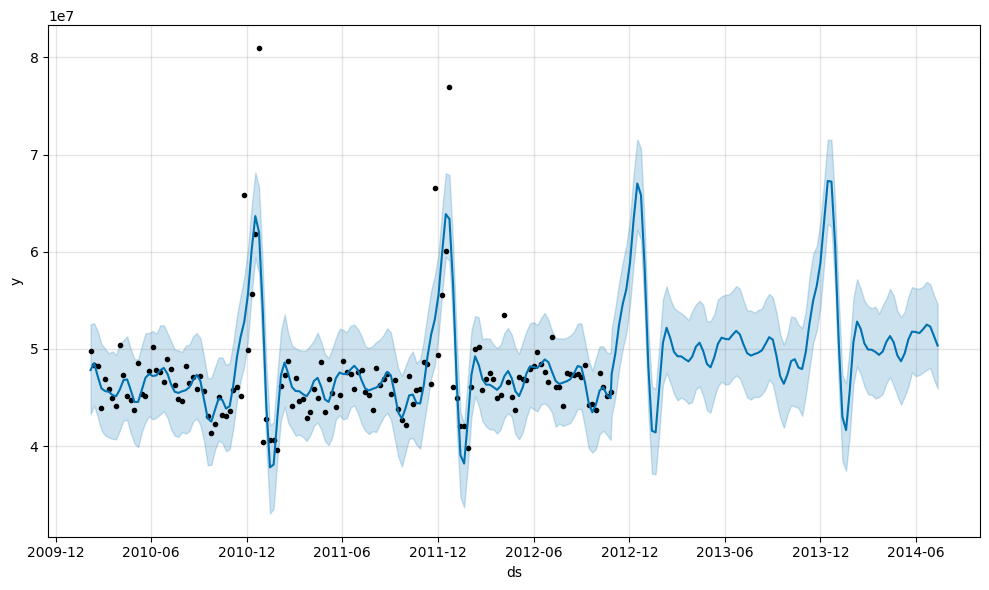

In [6]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = daily_sales.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Initialize and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# Make future dataframe (next 90 days)
future = model.make_future_dataframe(periods=90, freq="W")
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.show()


12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing


MAE: 811408.56
RMSE: 1050657.97


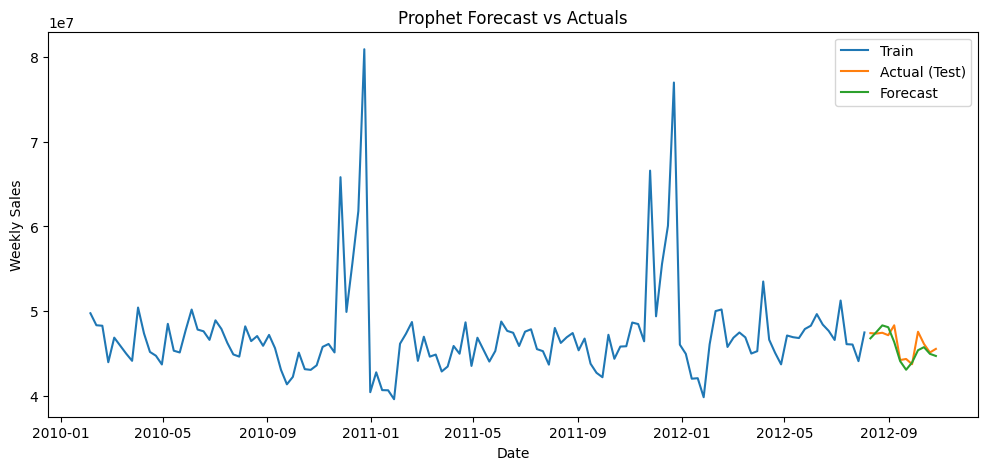

In [10]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("C:/Users/jbred/OneDrive/Desktop/retail-forecasting/data/raw/sales.csv")
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

# Aggregate total sales per week
daily_sales = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
daily_sales = daily_sales.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Split into train and test (last 12 weeks as test)
train = daily_sales.iloc[:-12]
test = daily_sales.iloc[-12:]

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

# Create future dataframe (12 weeks)
future = model.make_future_dataframe(periods=12, freq='W-FRI')  # match Walmart weekly frequency

# Predict
forecast = model.predict(future)

# Merge forecast with test set on 'ds'
forecast_filtered = forecast[["ds", "yhat"]].merge(test, on="ds", how="inner")

# Extract predictions and actuals
preds = forecast_filtered["yhat"]
actuals = forecast_filtered["y"]

# Calculate metrics
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# Plot results
plt.figure(figsize=(12,5))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Actual (Test)')
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Forecast')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Prophet Forecast vs Actuals")
plt.show()


In [9]:
# Check your dataset frequency
print(daily_sales['ds'].head(10))


0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
5   2010-03-12
6   2010-03-19
7   2010-03-26
8   2010-04-02
9   2010-04-09
Name: ds, dtype: datetime64[ns]


In [11]:
import pandas as pd

# Copy original data
data_ml = df.copy()

# Convert date
data_ml['Date'] = pd.to_datetime(data_ml['Date'], dayfirst=True)

# Sort
data_ml = data_ml.sort_values(['Store', 'Date'])

# Lag features (1, 2, 4 weeks)
for lag in [1, 2, 4]:
    data_ml[f'lag_{lag}'] = data_ml.groupby('Store')['Weekly_Sales'].shift(lag)

# Rolling mean (4 weeks)
data_ml['rolling_4'] = data_ml.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).mean()

# Time features
data_ml['week_of_year'] = data_ml['Date'].dt.isocalendar().week
data_ml['month'] = data_ml['Date'].dt.month
data_ml['year'] = data_ml['Date'].dt.year

# Drop rows with NaN (due to lag/rolling)
data_ml = data_ml.dropna()

data_ml.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,lag_1,lag_2,lag_4,rolling_4,week_of_year,month,year
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,1409727.59,1611968.17,1643690.90,1.576836e+06,9,3,2010
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,1554806.68,1409727.59,1641957.44,1.554615e+06,10,3,2010
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,1439541.59,1554806.68,1611968.17,1.504011e+06,11,3,2010
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,1472515.79,1439541.59,1409727.59,1.469148e+06,12,3,2010
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,1404429.92,1472515.79,1554806.68,1.467823e+06,13,4,2010


In [12]:
# Sort by date
data_ml = data_ml.sort_values(['Store', 'Date'])

# Split: last 12 weeks as test
train = data_ml[data_ml['Date'] < '2012-01-01']  # adjust date based on dataset
test = data_ml[data_ml['Date'] >= '2012-01-01']

# Features
features = ['lag_1','lag_2','lag_4','rolling_4','week_of_year','month','year',
            'Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']

X_train = train[features]
y_train = train['Weekly_Sales']

X_test = test[features]
y_test = test['Weekly_Sales']


In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize model
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
preds = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 49104.84799386305
RMSE: 69294.53273612149


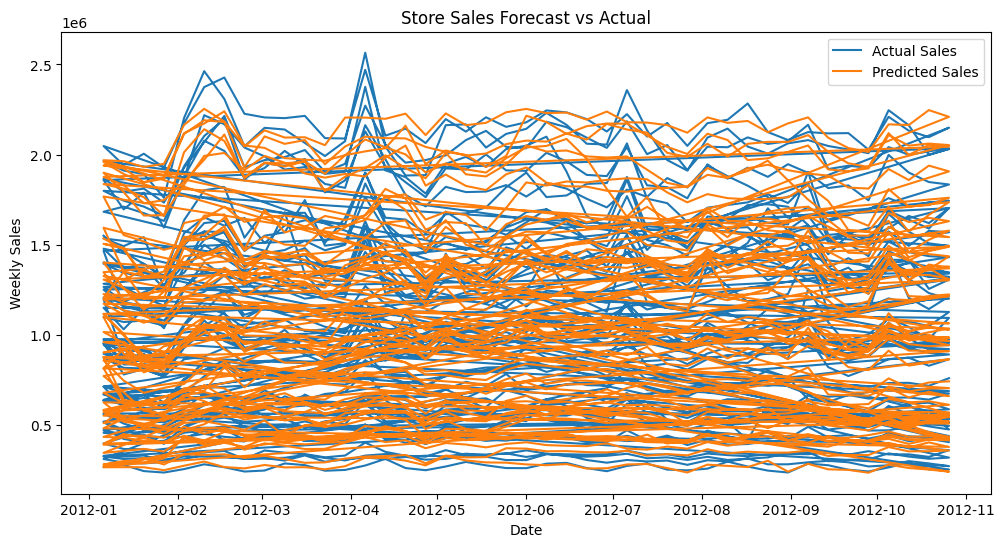

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Actual Sales')
plt.plot(test['Date'], preds, label='Predicted Sales')
plt.title("Store Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


In [17]:
import joblib

joblib.dump(model, 'xgb_sales_model.joblib')


['xgb_sales_model.joblib']

NoCredentialsError: Unable to locate credentials